In [1]:
%pip install cvxopt

import yfinance as yf
import numpy as np
import pandas as pd
import pandas_ta as ta
import cvxopt


Note: you may need to restart the kernel to use updated packages.


In [2]:
def fetch_data(ticker='SPY', start='2015-01-01', end='2023-12-31'):
    data = yf.download(ticker, start, end)
    data = data[['Close']]
    data.dropna(inplace=True)
    return data

def simple_moving_average(data, window=15):
    df = data.copy()
    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
    return df

def exponential_moving_average(data, span=20):
    df = data.copy()
    df[f'EMA_{span}'] = df['Close'].ewm(span=span, adjust=False).mean()
    return df


def relative_strength_index_ema(data,window=14):
    df = data.copy()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down =  delta.clip(upper=0).abs()
    avg_gain = up.ewm(window,adjust=False).mean()
    avg_loss = down.ewm(window,adjust=False).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}_ema'] = 100 - (100 / (1 + rs))
    return df

def relative_strength_index_sma(data,window=14):
    df = data.copy()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down =  delta.clip(upper=0).abs()
    avg_gain = up.rolling(window=window).mean()
    avg_loss = down.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}_sma'] = 100 - (100 / (1 + rs))
    return df


def bollinger_bands(data):
    df = data.copy()
    sma = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = sma + 2 * std
    df['Bollinger_Lower'] = sma - 2 * std
    return df

def macd_ewm(data):
    df = data.copy()
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df


def daily_return(data):
    df= data.copy()
    df['Daily_Return'] = df['Close'].pct_change()
    return df

def rolling_volatility(data):
    df = data.copy()
    #df['Daily_Return'] = df['Close'].pct_change()
    df['Rolling_5d_Std'] = df['Daily_Return'].rolling(window=5).std()
    return df

def lagged_returns(data):
    df = data.copy()
    #df['Daily_Return'] = df['Close'].pct_change()
    df['Lag_1'] = df['Daily_Return'].shift(1)
    df['Lag_2'] = df['Daily_Return'].shift(2)
    df['Lag_3'] = df['Daily_Return'].shift(3)
    return df

def compute_technical_indicators(data):
    df = data.copy()
    # Momentum
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    return df

In [3]:
data = fetch_data('SPY', '2015-01-01', '2025-07-05')
data = simple_moving_average(data, window=15)
data = exponential_moving_average(data, span=20)
data = relative_strength_index_ema(data, window=14)
data = relative_strength_index_sma(data, window=14)
data = bollinger_bands(data)
data = macd_ewm(data)
data = daily_return(data)
data = rolling_volatility(data)
data = lagged_returns(data)
data = compute_technical_indicators(data)

C:\Users\Micha\AppData\Local\Temp\ipykernel_22440\24724489.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [4]:
data['Daily_Return_Sign'] = np.where(data['Daily_Return'].shift(-1) > 0, 1, -1)
data = data.dropna()
data = data.drop(columns=['Close','Daily_Return'])  
data


Price,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign
Ticker,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,
2015-01-30,169.063657,169.370530,23.546649,39.839204,172.828052,165.551758,-0.636616,-0.474051,0.010508,0.009244,-0.012825,-0.013191,0.359100,1
2015-02-02,168.933929,169.300634,28.787190,48.509630,172.510248,165.576422,-0.616101,-0.502461,0.013018,-0.012575,0.009244,-0.012825,0.242249,1
2015-02-03,169.055863,169.469650,34.475978,55.141512,172.744048,165.603196,-0.398470,-0.481663,0.013672,0.012384,-0.012575,0.009244,2.321762,-1
2015-02-04,169.166104,169.560527,33.705347,56.060577,172.791634,165.909718,-0.275387,-0.440407,0.011650,0.014461,0.012384,-0.012575,0.818451,1
2015-02-05,169.458971,169.806603,37.649046,63.335694,173.162843,165.856710,-0.038571,-0.360040,0.011753,-0.003808,0.014461,0.012384,0.016678,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,601.389893,598.693038,69.373928,68.391896,612.911016,585.016236,7.985536,7.483408,0.004208,0.007824,0.000560,0.011047,12.939575,1
2025-06-30,602.754956,600.517509,70.938957,69.907840,615.740797,585.206175,8.552787,7.697283,0.003899,0.004968,0.007824,0.000560,22.609680,-1


In [5]:
# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
    print(f"{repo_root} added to sys.path.")
else:
    print("Repo root already in sys.path.")

c:\Users\Micha\.vscode added to sys.path.


In [6]:
from courselib.utils.splits import train_test_split
from courselib.utils.normalization import standardize
training_data_fraction = .8
X, Y, X_train, Y_train, X_test, Y_test = train_test_split(data, training_data_fraction=0.8, class_column_name='Daily_Return_Sign', return_numpy=True)
X = standardize(X)
X_test = standardize(X_test)
X_train = standardize(X_train)


In [7]:
from courselib.models.svm import LinearSVM
from courselib.optimizers import GDOptimizer
from courselib.utils.metrics import binary_accuracy

w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true), 
                "loss": lambda y_pred, y_true: np.mean(np.maximum(0, 1 - y_true * y_pred))}

svm = LinearSVM(w, b, optimizer, C=1.)
metrics_history = svm.fit(X_train,Y_train, num_epochs = 50000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

In [8]:
svm.w, svm.b

(array([ 0.00486538,  0.00488413, -0.00396202, -0.00182073,  0.00451747,
         0.0050666 ,  0.0030934 ,  0.00152195, -0.00373635,  0.00894956,
         0.00520854, -0.00556835,  0.0014061 ,  0.49778691]),
 array(0.50173386))

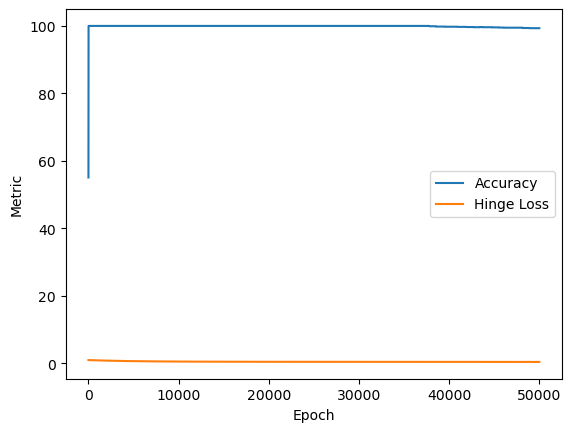

In [9]:
import matplotlib.pyplot as plt

plt.plot(metrics_history["accuracy"], label="Accuracy")
plt.plot(metrics_history["loss"], label="Hinge Loss")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.show()


In [10]:
y_pred_test = svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)

Test Accuracy: 95.0381679389313


In [11]:
from courselib.models.glm import LogisticRegression
w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true), 
                "loss": lambda y_pred, y_true: np.mean(np.maximum(0, 1 - y_true * y_pred))}
logistic_regression = LogisticRegression(w, b, optimizer)
metrics_history = logistic_regression.fit(X_train, Y_train, num_epochs=50000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)
logistic_regression.w, logistic_regression.b

(array([ 0.03579104,  0.03571731, -0.0259341 , -0.01391025,  0.03334914,
         0.03713063,  0.0270785 ,  0.01649564, -0.01371496,  0.07505162,
         0.03512003, -0.03487325,  0.01281437,  3.50568275]),
 array(-1.66164447))

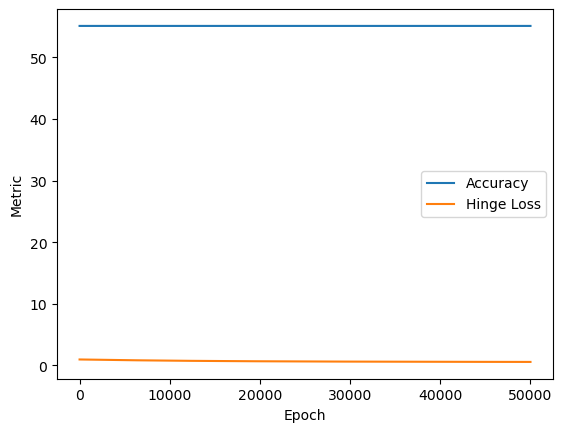

In [12]:
plt.plot(metrics_history["accuracy"], label="Accuracy")
plt.plot(metrics_history["loss"], label="Hinge Loss")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.show()

In [13]:
y_pred_test = logistic_regression(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)

Test Accuracy: 53.81679389312977


In [20]:
# Trading Strategy

# Example DataFrame
data = {
    'price': [100, 102, 101, 105, 107, 106],
    'signal': [1, 1, 1, -1, -1, 1]
}

df = pd.DataFrame(data)

# 1. Compute daily asset returns
df['return'] = df['price'].pct_change()

# 2. Shift the signal if needed (optional)
# You might want to execute the trade next day, so shift by 1
df['signal_shifted'] = df['signal'].shift(-1)

# 3. Strategy daily return: asset return * signal
df['strategy_return'] = df['return'] * df['signal_shifted']

# 4. Cumulative returns
df['cumulative_strategy'] = (1 + df['strategy_return']).cumprod()
df['cumulative_asset'] = (1 + df['return']).cumprod()

print(df)


   price  signal    return  signal_shifted  strategy_return  \
0    100       1       NaN             1.0              NaN   
1    102       1  0.020000             1.0         0.020000   
2    101       1 -0.009804            -1.0         0.009804   
3    105      -1  0.039604            -1.0        -0.039604   
4    107      -1  0.019048             1.0         0.019048   
5    106       1 -0.009346             NaN              NaN   

   cumulative_strategy  cumulative_asset  
0                  NaN               NaN  
1             1.020000              1.02  
2             1.030000              1.01  
3             0.989208              1.05  
4             1.008050              1.07  
5                  NaN              1.06  


In [17]:

def pca_numpy(X: np.ndarray, n_components: int = 2):
    """
    Perform PCA using numpy.

    Parameters:
    -----------
    X : np.ndarray
        The input data matrix, shape (n_samples, n_features).
    n_components : int
        Number of principal components to keep.

    Returns:
    --------
    X_reduced : np.ndarray
        The projected data onto top principal components.
    explained_variance_ratio : np.ndarray
        Percentage of variance explained by each selected component.
    components : np.ndarray
        The eigenvectors (principal axes).
    """
    # 1) Center the data
    X_meaned = X - np.mean(X, axis=0)

    # 2) Covariance matrix
    cov_mat = np.cov(X_meaned, rowvar=False)

    # 3) Eigen decomposition
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)

    # 4) Sort eigenvalues and eigenvectors in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[sorted_index]
    eigen_vectors = eigen_vectors[:, sorted_index]

    # 5) Select top k eigenvectors
    eigenvector_subset = eigen_vectors[:, 0:n_components]

    # 6) Project the data
    X_reduced = np.dot(X_meaned, eigenvector_subset)

    # 7) Explained variance ratio
    explained_variance_ratio = eigen_values / np.sum(eigen_values)

    return X_reduced, explained_variance_ratio[:n_components], eigenvector_subset


In [19]:
X_reduced, explained_var, components = pca_numpy(X, n_components=5)
X_reduced, explained_var, components

(array([[-1.95039577, -0.69642373,  0.52362488, -0.96486473, -0.98205661],
        [-0.00701746, -1.73654257, -0.11768116,  0.13845482, -0.71565095],
        [ 3.31908394,  3.79563752, -0.23778593,  1.37616671,  0.90789403],
        ...,
        [ 1.67843318,  1.28161776,  1.69220902,  1.28974364, -0.71176946],
        [ 0.08489158, -1.12638701, -0.62415551, -0.50814602, -0.88926274],
        [-2.31781332,  1.11952228, -0.3998805 ,  0.82717585, -0.80170622]]),
 array([0.31817326, 0.26906026, 0.08745627, 0.08080244, 0.07218882]),
 array([[-0.32545312,  0.37355903,  0.01616771, -0.02676965,  0.00662382],
        [-0.32360674,  0.37497652,  0.02102002, -0.03619402,  0.0076084 ],
        [-0.31936799, -0.30977895,  0.07165228, -0.14744244,  0.00400871],
        [-0.28739446, -0.30416784,  0.09334338, -0.20645688,  0.02016489],
        [-0.31196413,  0.38558363,  0.02852733, -0.05061443,  0.00948868],
        [-0.32959612,  0.36851032,  0.00811884, -0.010343  ,  0.00390839],
        [-0.373